In [25]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pprint import pprint

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Number of available GPUs:  2


The entire processed dataset is contained within `dataset.npz`, so load it.

In [26]:
data_dir = config['data_dir']

with np.load(os.path.join(data_dir, 'dataset.npz')) as data:
    hsc_lenses = data['hsc_lens']
    hsc_nonlenses = data['hsc_nonlens']
    slsim_lenses = data['slsim_lens']
    slsim_nonlenses = data['slsim_nonlens']

print(f'hsc_lens: {hsc_lenses.shape}')
print(f'hsc_nonlens: {hsc_nonlenses.shape}')
print(f'slsim_lens: {slsim_lenses.shape}')
print(f'slsim_nonlens: {slsim_nonlenses.shape}')

hsc_lens: (50000, 41, 41, 5)
hsc_nonlens: (50000, 41, 41, 5)
slsim_lens: (50000, 41, 41, 5)
slsim_nonlens: (50000, 41, 41, 5)


Take a quick look at the four parts of the dataset: 
1. HSC Lenses
2. HSC Nonlenses
3. SLSim Lenses
4. SLSim Nonlenses

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(11.4, 12), constrained_layout=True)

datasets = [
    (slsim_lenses, "slsim_lenses"),
    (hsc_lenses, "hsc_lenses"),
    (slsim_nonlenses, "slsim_nonlenses"),
    (hsc_nonlenses, "hsc_nonlenses"),
]

for ax, (images, title) in zip(axes.flat, datasets):
    grid_size = min(25, len(images))
    grid_rows = grid_cols = int(np.ceil(np.sqrt(grid_size)))
    for i in range(grid_size):
        row = i // grid_cols
        col = i % grid_cols
        sub_ax = ax.inset_axes([col/grid_cols, 1-row/grid_rows-1/grid_rows, 1/grid_cols, 1/grid_rows])
        sub_ax.imshow(images[i][:,:,:3])
        sub_ax.axis("off")  # Hide axes for each image
    ax.set_title(title)
    ax.axis("off")  # Hide main axes

plt.suptitle('Dataset Sample')
plt.show()

Organize these four pieces into `data` and `labels` so that we can import it in a way that Tensorflow likes

In [ ]:
data = np.concatenate([hsc_lenses, slsim_lenses, hsc_nonlenses, slsim_nonlenses], axis=0)
labels = np.array(([1] * (len(hsc_lenses) + len(slsim_lenses))) + ([0] * (len(hsc_nonlenses) + len(slsim_nonlenses))), dtype=np.uint8)
print(data.shape)
print(labels.shape)

(200000, 41, 41, 5)
(200000,)


Import the data and labels to a Tensorflow `Dataset`

In [ ]:
ds = tf_data.Dataset.from_tensor_slices((data, labels))
ds = ds.shuffle(buffer_size=len(labels), reshuffle_each_iteration=True)

I0000 00:00:1757958934.068160 2916133 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46551 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1757958934.069447 2916133 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46551 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Split the whole dataset into a training, validation, and test set. The training and validation sets are used in the training process, and the test set is used to evaluate the model's performance against data it hasn't been trained on.

In [ ]:
# Calculate split sizes
total_size = len(labels)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
print(f'end={total_size}, train={train_size}, val={val_size}, test={test_size}')

# Split the dataset
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)

print(f"Train size: {train_ds.cardinality()}, Val size: {val_ds.cardinality()}, Test size: {test_ds.cardinality()}")

end=200000, train=140000, val=40000, test=20000
Train size: 140000, Val size: 40000, Test size: 20000


"Data augmentation" is a way of increasing the size of our training set, which makes the neural net perform better. Here, we're randomly flipping and rotating the images.

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.batch(32).prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf_data.AUTOTUNE)

Build the model

In [ ]:
# def make_model(input_shape, num_classes):
#     inputs = layers.Input(shape=input_shape)

#     # Entry block
#     x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.GlobalAveragePooling2D()(x)

#     x = layers.Dropout(0.5)(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     outputs = layers.Dense(units, activation=None)(x)
    
#     return models.Model(inputs, outputs)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    num_bands = input_shape[2]

    # Entry block
    x = layers.Conv2D(128, num_bands, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, num_bands, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(num_bands, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, num_bands, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(41, 41, 5), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

Train the model

In [ ]:
epochs = 50

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  # Or "/cpu:0" if no GPU  # MirroredStrategy()
with strategy.scope():
    model = make_model(input_shape=(41, 41, 5), num_classes=2)
    # keras.utils.plot_model(model, show_shapes=True)

    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )

    callbacks = [
        # keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds,
    )

Epoch 1/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - acc: 0.9025 - loss: 0.2204 - val_acc: 0.9012 - val_loss: 0.2033
Epoch 2/50
2599/4375 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - acc: 0.9482 - loss: 0.1289

4375/4375 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - acc: 0.9489 - loss: 0.1269 - val_acc: 0.9278 - val_loss: 0.1482
Epoch 3/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - acc: 0.9574 - loss: 0.1062 - val_acc: 0.9579 - val_loss: 0.0981
Epoch 4/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - acc: 0.9640 - loss: 0.0920 - val_acc: 0.9302 - val_loss: 0.1739
Epoch 5/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - acc: 0.9664 - loss: 0.0846 - val_acc: 0.9401 - val_loss: 0.1397
Epoch 6/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - acc: 0.9703 - loss: 0.0769 - val_acc: 0.9633 - val_loss: 0.0925
Epoch 7/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - acc: 0.9721 - loss: 0.0729 - val_acc: 0.9591 - val_loss: 0.0865
Epoch 8/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 58s 12ms/step - acc: 0.9737 - loss: 0.0678 - val_acc: 0.9348 - val_loss: 0.1425
Epoch 9/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - acc: 0.9758 - loss: 0.0639 - val_acc: 0.9632 - val_loss: 0.0777
Epoch 10/50
4375/4375 ━━━━━━━━━━━━━

Plot the training and validation accuracy to sanity check that the training is going as expected. We can identify overfitting and underfitting by looking at this figure:
- Ideal Scenario: Training accuracy steadily increases and levels off at a high value. Validation accuracy follows closely and also levels off at a high value.
- Overfitting Scenario: Training accuracy keeps increasing and may reach 100%, but validation accuracy peaks early and then decreases.
- Underfitting Scenario: Both training and validation accuracy remain low.

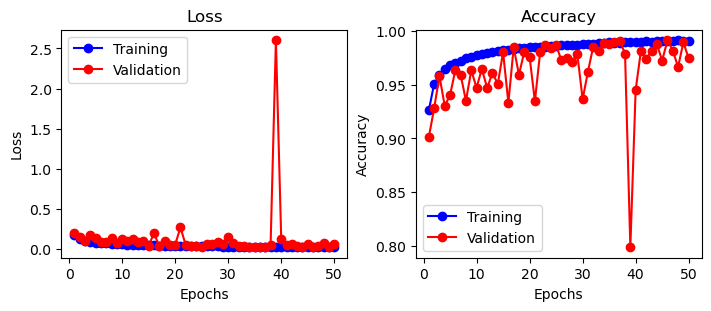

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

_, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
epoch_list = range(1, len(loss) + 1)

ax[0].plot(epoch_list, loss, 'bo-', label='Training')
ax[0].plot(epoch_list, val_loss, 'ro-', label='Validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0, 1)
ax[0].legend()

ax[1].plot(epoch_list, accuracy, 'bo-', label='Training')
ax[1].plot(epoch_list, val_accuracy, 'ro-', label='Validation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim(0, 1)
ax[1].legend()

plt.show()

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.07817849516868591
Test accuracy: 0.973800003528595


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


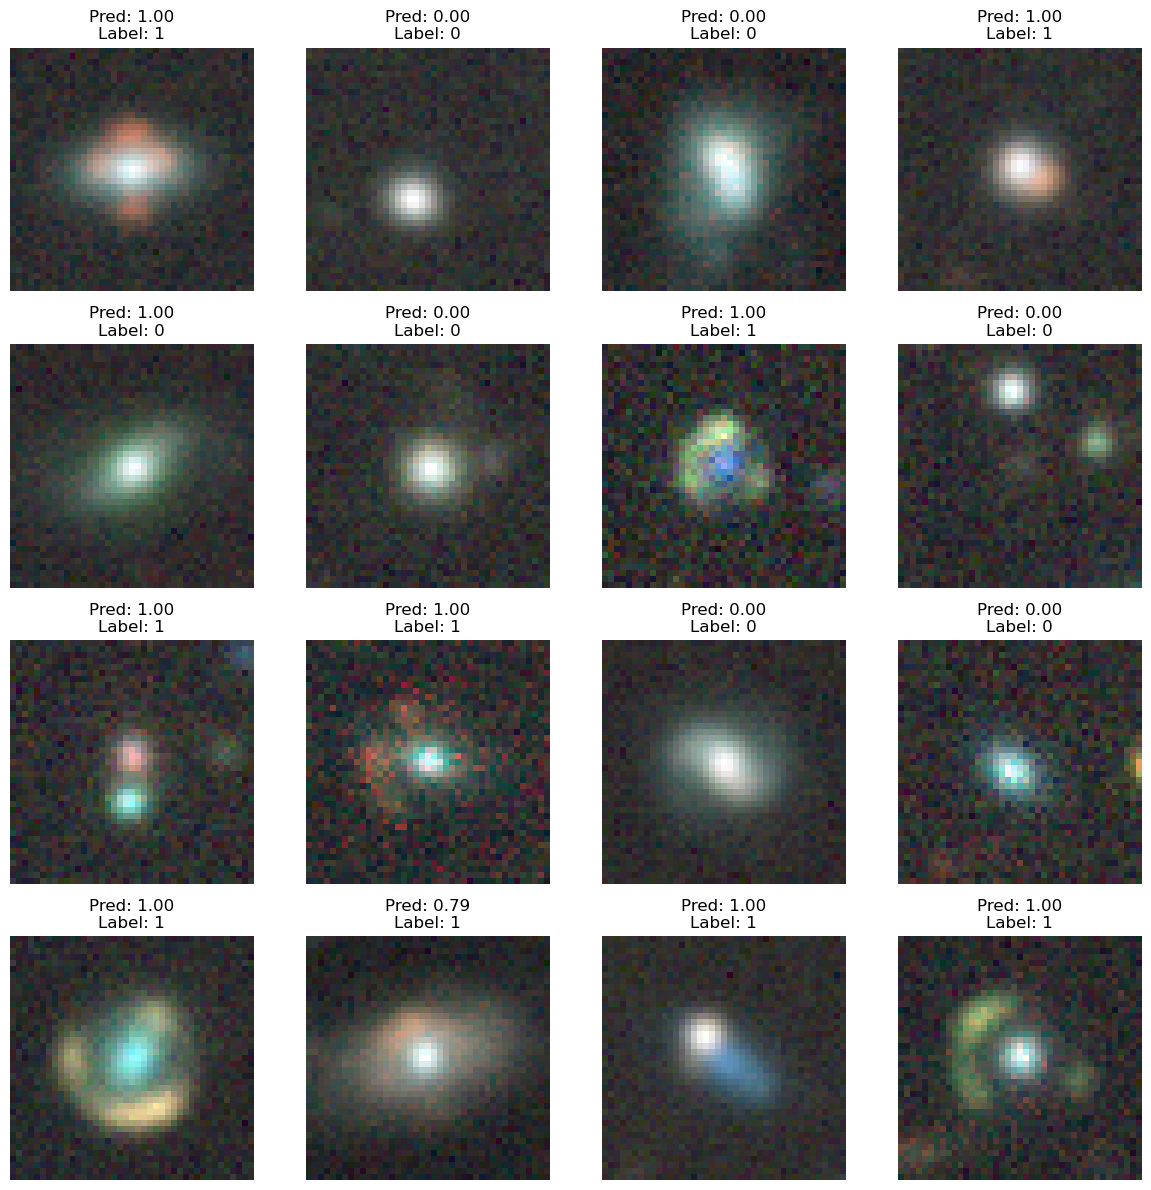

In [ ]:
plt.figure(figsize=(12, 12))
for idx, (images_batch, labels_batch) in enumerate(test_ds.take(1)):
    preds = model.predict(images_batch)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    for i in range(min(16, images_batch.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy()[:,:,:3])
        plt.title(f"Pred: {probs[i]:.2f}\nLabel: {int(labels_batch[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

2025-09-15 15:06:45.235371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


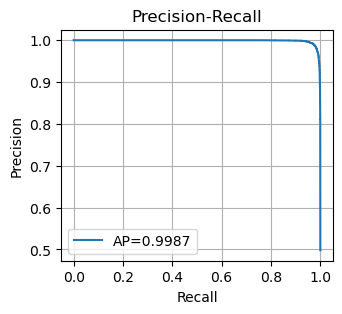

In [ ]:
# Collect predictions and true labels from test_ds
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    probs = keras.ops.sigmoid(preds).numpy().flatten()  # Use sigmoid to get probabilities
    y_scores.extend(probs)
    y_true.extend(labels_batch.numpy().flatten())

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.5, 3))
plt.plot(recall, precision, label=f'AP={ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()

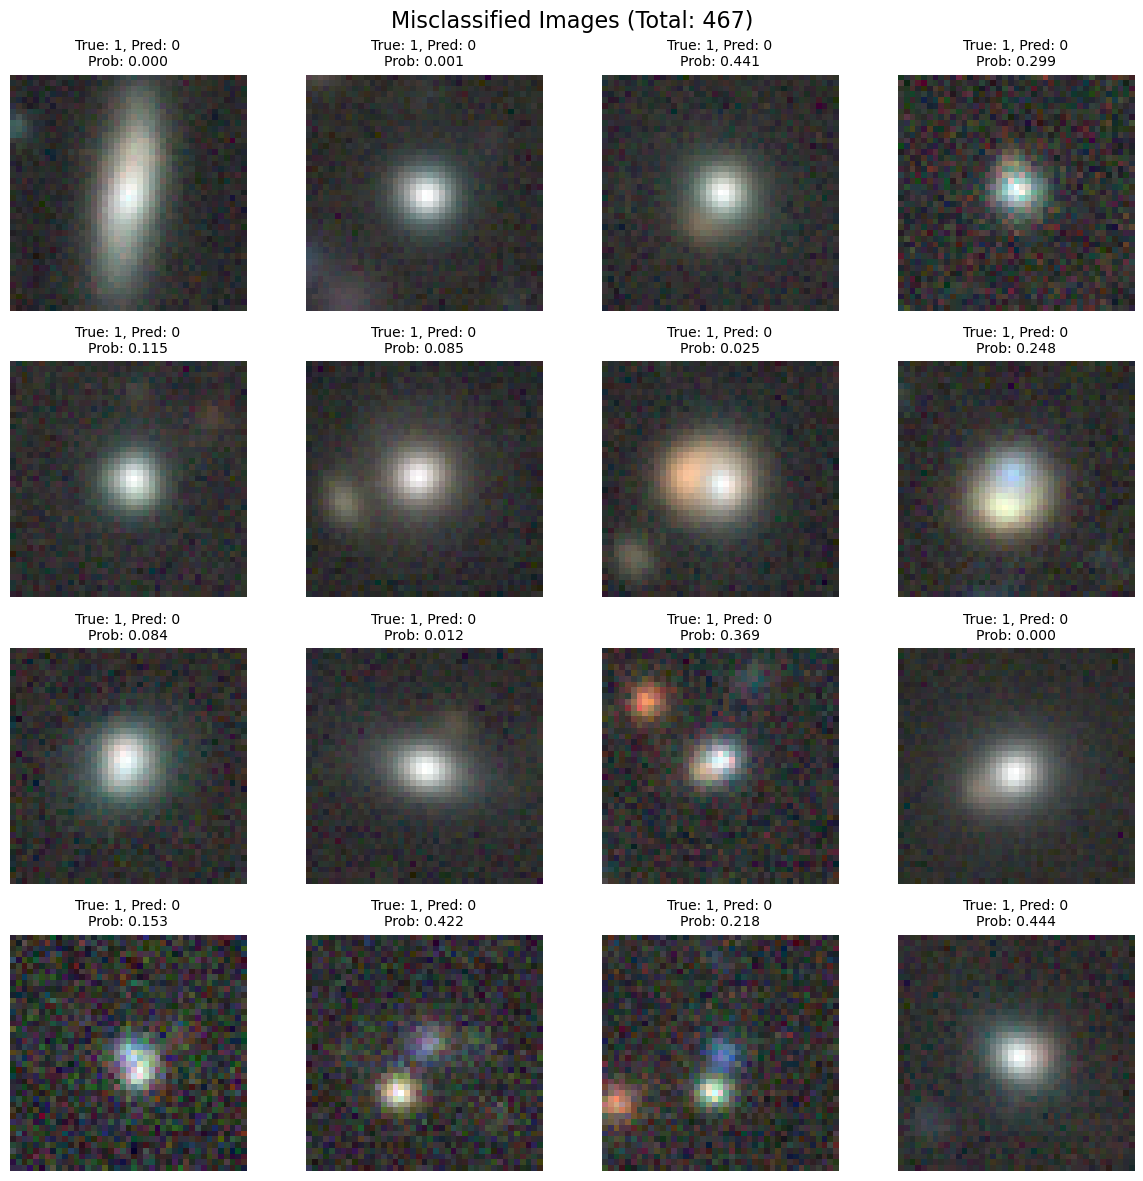

Total misclassified images: 467


In [ ]:
# Collect misclassified images
misclassified_images = []
misclassified_labels = []
misclassified_probs = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch, verbose=0)
    probs = keras.ops.sigmoid(preds).numpy().flatten()
    
    # Convert probabilities to binary predictions (threshold at 0.5)
    pred_labels = (probs > 0.5).astype(int)
    true_labels = labels_batch.numpy().flatten().astype(int)
    
    # Find misclassified samples
    misclassified_mask = pred_labels != true_labels
    
    if np.any(misclassified_mask):
        misclassified_images.extend(images_batch[misclassified_mask].numpy())
        misclassified_labels.extend(true_labels[misclassified_mask])
        misclassified_probs.extend(probs[misclassified_mask])

# Display misclassified images
num_to_show = min(16, len(misclassified_images))
if num_to_show > 0:
    plt.figure(figsize=(12, 12))
    for i in range(num_to_show):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(misclassified_images[i][:,:,:3])
        true_label = misclassified_labels[i]
        pred_prob = misclassified_probs[i]
        pred_label = 1 if pred_prob > 0.5 else 0
        plt.title(f"True: {true_label}, Pred: {pred_label}\nProb: {pred_prob:.3f}", fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Misclassified Images (Total: {len(misclassified_images)})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Total misclassified images: {len(misclassified_images)}")
else:
    print("No misclassified images found!")